In [36]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

import patsy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.linear_model import lars_path

%matplotlib inline

In [2]:
#Import of IMDB data cleaned in previous notebook
df = pd.read_pickle("./shows2.pkl")

### EDA, choosing features for Regression model

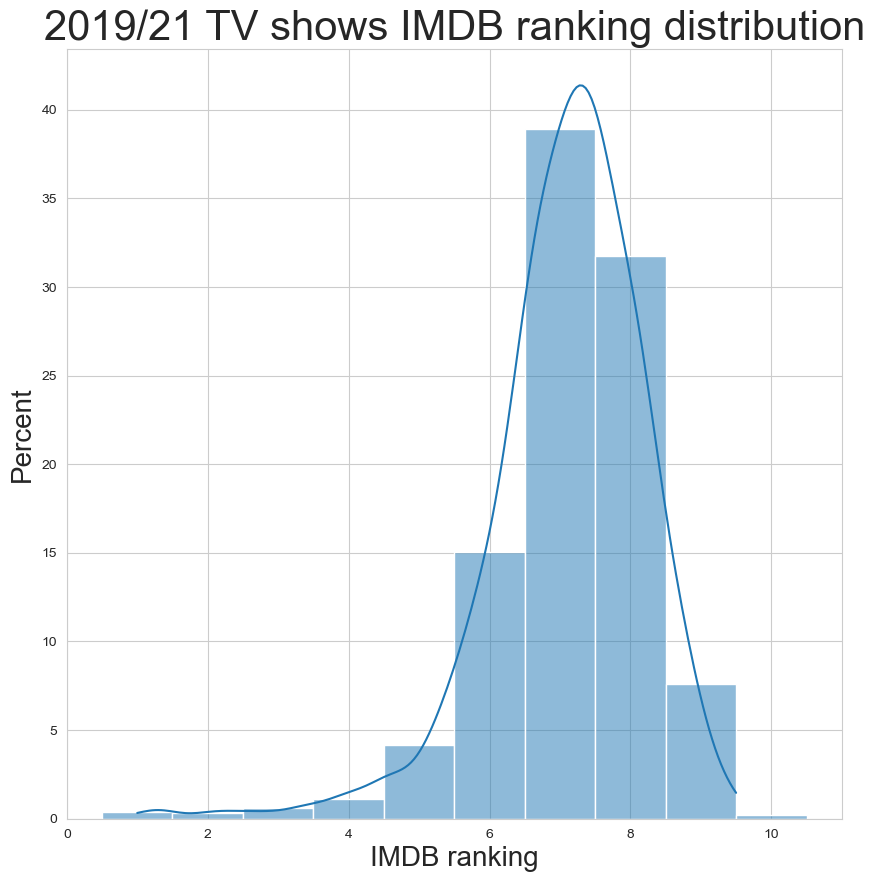

In [3]:
plt.figure(figsize = [10,10])
sns.set_style("whitegrid")
sns.histplot(df.imdb_rating, stat="percent", discrete=True, kde=True)
plt.title('2019/21 TV shows IMDB ranking distribution',  fontsize = 30)
plt.ylabel('Percent', fontsize = 20)
plt.xlabel('IMDB ranking', fontsize = 20)
plt.savefig('imdb_hist_plot', bbox_inches = 'tight');

In [4]:
#checking correlations between taget and features
x = df.corr().iloc[:,0]
x = list(x[abs(x)>0.05].index)
x

['imdb_rating',
 'avg_runtime',
 'Biography',
 'Horror',
 'Sci_Fi',
 'Short',
 'Game_Show',
 'News',
 'History',
 'Reality_TV',
 'Musical',
 'Sport',
 'TV_PG',
 'made_in_usa',
 'stars_a_n',
 'awards_n']

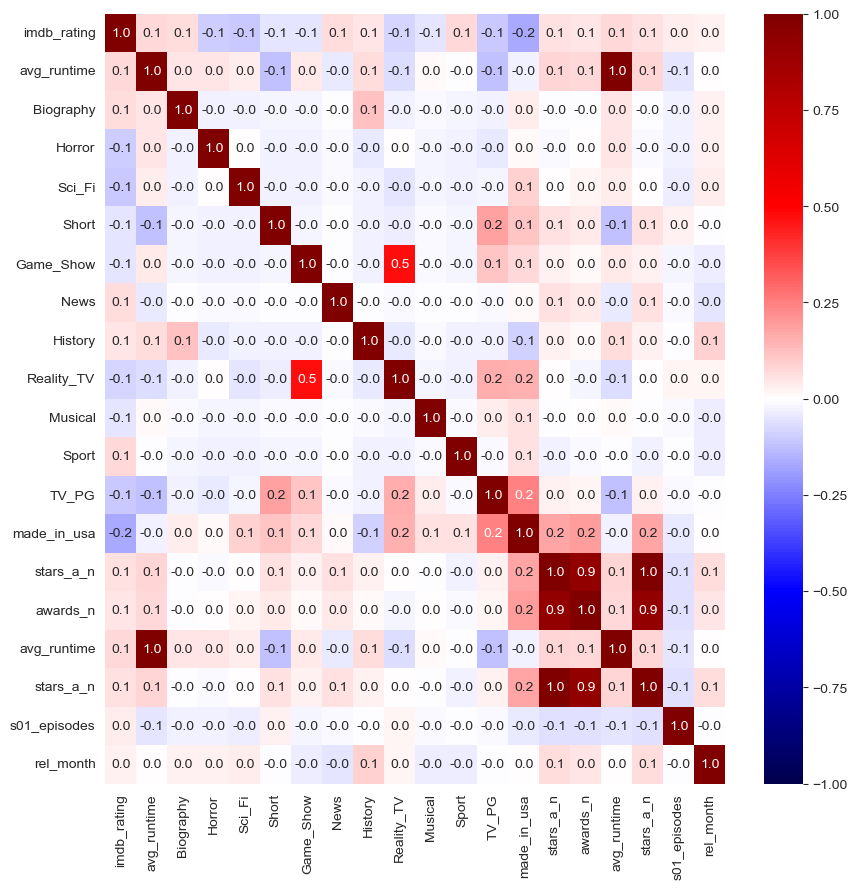

In [14]:
plt.figure(figsize = [10,10])
sns.heatmap(df[x + ['avg_runtime', 'stars_a_n', 's01_episodes', 'rel_month']].corr(), cmap="seismic", annot=True, fmt='.1f', vmin=-1, vmax=1)
plt.savefig('imdb_heat_map', bbox_inches = 'tight');

<Figure size 1000x1000 with 0 Axes>

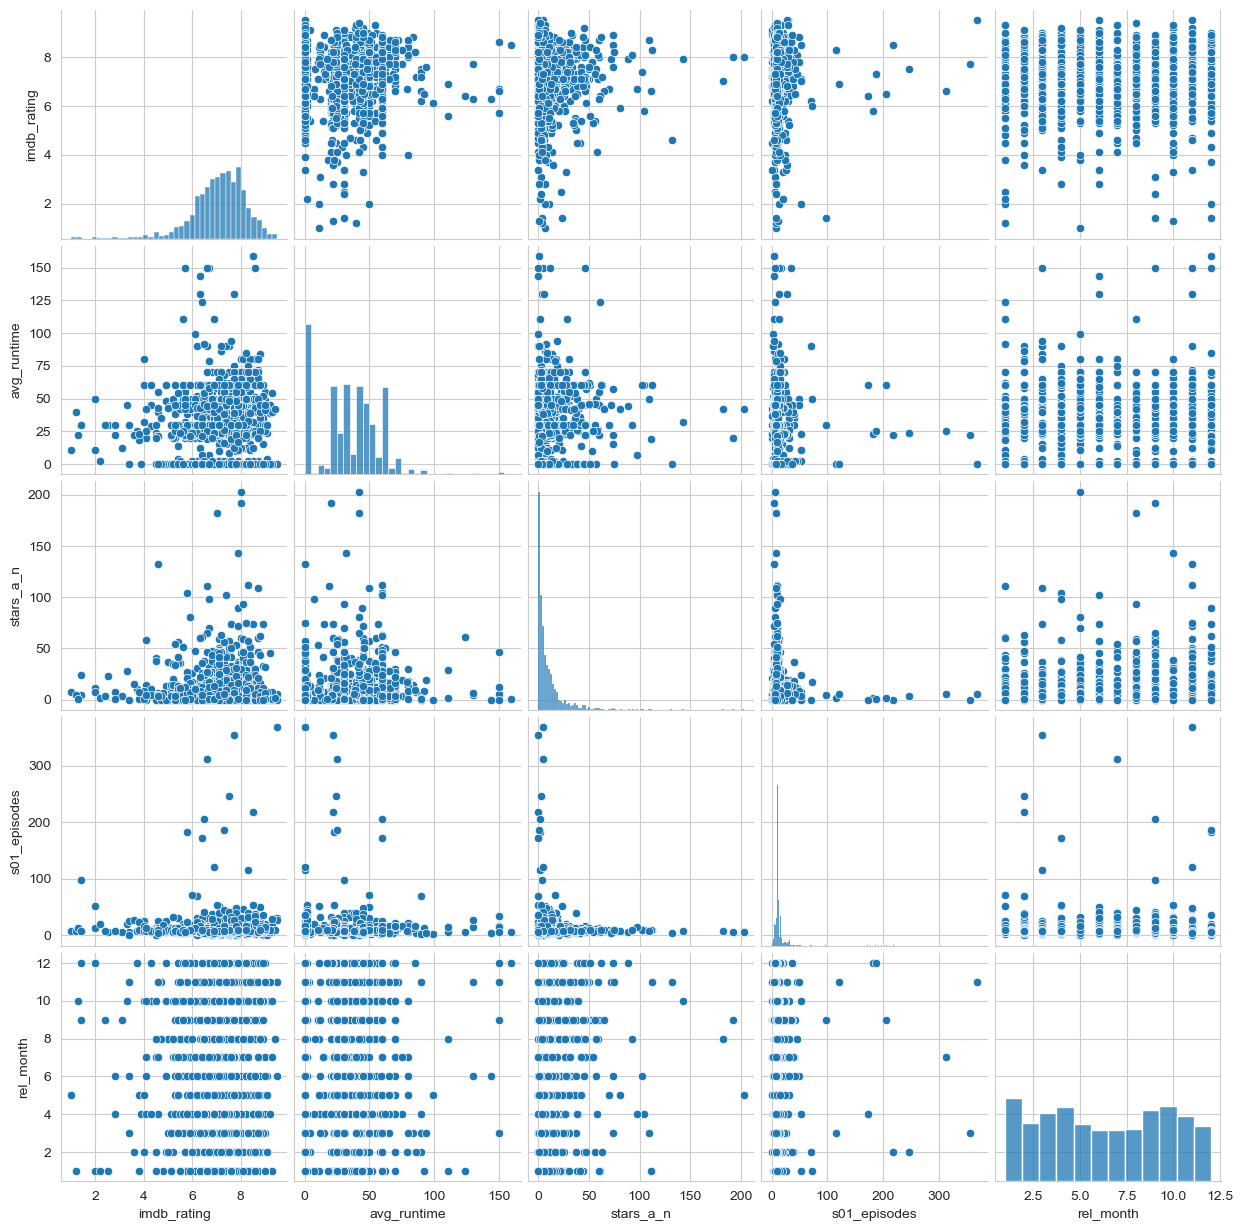

In [17]:
plt.figure(figsize = [10,10])
sns.pairplot(df[['imdb_rating', 'avg_runtime', 'stars_a_n', 's01_episodes', 'rel_month']])
plt.savefig('imdb_pair_plot', bbox_inches = 'tight');

<AxesSubplot:xlabel='s01_episodes'>

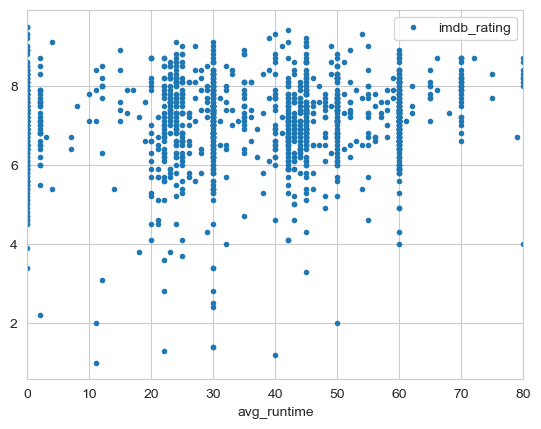

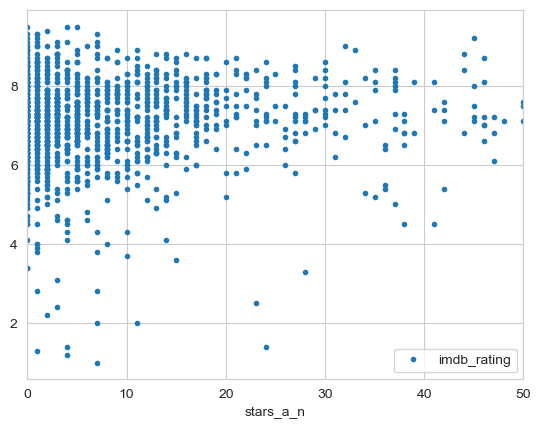

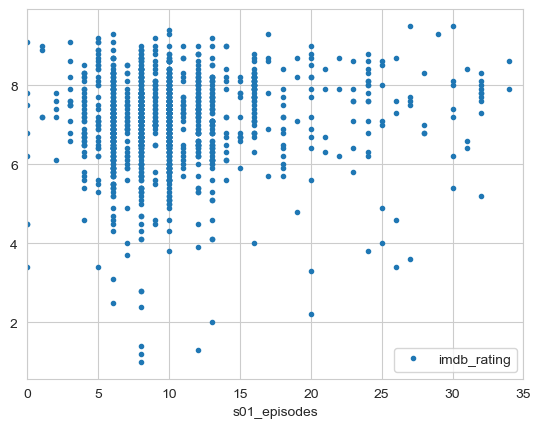

In [18]:
df.plot(x='avg_runtime',y='imdb_rating',style='.', xlim=(0,80))
df.plot(x='stars_a_n',y='imdb_rating',style='.', xlim=(0,50))
df.plot(x='s01_episodes',y='imdb_rating',style='.', xlim=(0,35))

In [19]:
#experiments with features
#df['real_game'] = ((df['made_in_usa'] == 1)&(df['TV_PG'] == 1)).apply(int)
#df['US_PG'] = ((df['made_in_usa'] == 1)&(df['TV_PG'] == 1)).apply(int)
#df['US_horror'] = ((df['made_in_usa'] == 1)&(df['Horror'] == 1)).apply(int)
#df['US_scifi'] = ((df['made_in_usa'] == 1)&(df['Sci_Fi'] == 1)).apply(int)
#df['long_stars'] = (df['avg_runtime']*df['stars_a_n']).apply(int)

In [20]:
df

,link,imdb_rating,title,s01_episodes,avg_runtime,genres,rel_date,certification,origin,company,...,rel_month,TV_PG,TV_14,TV_MA,made_in_usa,big_c,company_n,creators_a_n,stars_a_n,awards_n
0,https://www.imdb.com/title/tt7670568,5.8,The Masked Singer,10,60,"[Game-Show, Music, Reality-TV]",2019-01-02,TV-PG,United States,"[Smart Dog Media, Fox Alternative Entertainmen...",...,1,1,0,0,1,0,3,0,9,9
1,https://www.imdb.com/title/tt8001250,6.2,Siempre Bruja,11,40,"[Drama, Fantasy]",2019-01-01,TV-14,Colombia,[Caracol],...,1,0,1,0,0,0,1,0,0,0
2,https://www.imdb.com/title/tt8115560,6.6,Tidying Up with Marie Kondo,8,40,[Reality-TV],2019-01-01,TV-PG,United States,"[Netflix, The Jackal Group]",...,1,1,0,0,1,1,2,1,1,2
3,https://www.imdb.com/title/tt8324422,8.1,PEN15,10,30,[Comedy],2019-02-08,TV-MA,United States,"[Awesomeness TV, Odenkirk Provissiero Entertai...",...,2,0,0,1,1,0,3,6,7,13
4,https://www.imdb.com/title/tt8888322,6.6,Bloom,6,60,"[Drama, Mystery, Sci-Fi]",2019-01-01,0,Australia,[Playmaker Media],...,1,0,0,0,0,0,1,5,12,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1350,https://www.imdb.com/title/tt16385150,8.9,Shark Tank India,36,0,[Reality-TV],2021-12-20,0,India,[],...,12,0,0,0,0,0,0,0,0,0
1351,https://www.imdb.com/title/tt16477402,8.2,WWII in Color: Road to Victory,10,50,"[Documentary, History, War]",2021-12-22,0,United Kingdom,[],...,12,0,0,0,0,0,0,0,0,0
1352,https://www.imdb.com/title/tt11570202,6.9,The Silent Sea,8,45,"[Adventure, Drama, Mystery]",2021-12-24,TV-MA,South Korea,[Artist Studio],...,12,0,0,1,0,0,1,0,13,13
1353,https://www.imdb.com/title/tt13668894,7.3,The Book of Boba Fett,7,38,"[Action, Adventure, Sci-Fi]",2021-12-29,TV-14,United States,"[Golem Creations, Lucasfilm]",...,12,0,1,0,1,0,2,11,5,16


### Regression model

In [22]:
#y, X = patsy.dmatrices('imdb_rating ~  s01_episodes + avg_runtime + Horror + Romance + Short + Crime + Game_Show + Sport + Documentary + Biography + Musical + Western + Reality_TV + History + Family + Sci_Fi + Thriller+ Animation + News + TV_PG + TV_MA + made_in_usa + stars_a_n + awards_n + big_c', data=df, return_type="dataframe")
y = df.imdb_rating
X = df.drop(columns=['imdb_rating', 'link', 'title', 'genres', 'rel_date', 'certification', 'origin', 'creators', 'stars', 'creators_a', 'stars_a', 'company'], axis=1)
X = sm.add_constant(X).astype(float)

STANDARD SCALER

In [23]:
scaler = StandardScaler()
for i in ['s01_episodes', 'avg_runtime','creators_a_n', 'stars_a_n', 'awards_n']:
    X[i] = pd.DataFrame(scaler.fit_transform(X[[i]]), columns=[i])

DATA SPIT FOR TESTING

In [26]:
#As there is relatively not a lot of data points, I hold out 25% of the data for final testing, I could proceed with K fold but to keep it simple I stay with that solution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=10)

INITIAL MODEL

In [27]:
model = sm.OLS(y_train, X_train)

fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     3.592
Date:                Mon, 09 Jan 2023   Prob (F-statistic):           9.13e-12
Time:                        19:14:22   Log-Likelihood:                -1515.3
No. Observations:                1016   AIC:                             3107.
Df Residuals:                     978   BIC:                             3294.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            7.0789      0.151     46.814      0.000       6.782       7.376
s01_episodes     0.0635      0.033      1.929      0.054      -0.001       0.128
avg_runtime      0.1145      0.038      2.978      0.003       0.039       0.190
Thriller        -0.0873      0.126     -0.694      0.488      -0.334       0.160
Music           -0.0180      0.249     -0.072      0.942      -0.507       0.471
Comedy           0.0145      0.101      0.143      0.886      -0.184       0.213
Biography        0.3157      0.272      1.163      0.245      -0.217       0.849
Adventure        0.0512      0.144      0.354      0.723      -0.232       0.335
Horror          -0.6007      0.200     -3.003      0.003      -0.993      -0.208
Documentary      0.1100      0.171      0.642      0.521      -0.226       0.446
Western          1.0343      0.756      1.368      0.172      -0.449       2.518
Sci_Fi          -0.5131      0.169     -3.028      0.003      -0.846      -0.181
Romance          0.0237      0.123      0.193      0.847      -0.217       0.264
Short           -0.2433      0.253     -0.961      0.337      -0.740       0.254
Mystery         -0.1717      0.126     -1.366      0.172      -0.418       0.075
Action          -0.2839      0.126     -2.260      0.024      -0.530      -0.037
Family          -0.2631      0.253     -1.041      0.298      -0.759       0.233
Game_Show       -0.2310      0.343     -0.673      0.501      -0.905       0.443
News             3.1249      1.178      2.652      0.008       0.812       5.437
Talk_Show       -1.5779      0.507     -3.111      0.002      -2.573      -0.583
War             -0.1550      0.415     -0.373      0.709      -0.970       0.660
Crime            0.0479      0.109      0.442      0.659      -0.165       0.261
History         -0.0627      0.212     -0.295      0.768      -0.480       0.354
Drama           -0.0911      0.102     -0.894      0.372      -0.291       0.109
Reality_TV      -0.0482      0.202     -0.239      0.811      -0.444       0.348
Animation        0.2527      0.142      1.781      0.075      -0.026       0.531
Musical         -0.9316      0.440     -2.119      0.034      -1.794      -0.069
Sport            0.5228      0.260      2.010      0.045       0.012       1.033
Fantasy         -0.0807      0.150     -0.538      0.591      -0.375       0.214
genres_n         0.1382      0.075      1.837      0.066      -0.009       0.286
rel_month        0.0035      0.010      0.351      0.725      -0.016       0.023
TV_PG           -0.3883      0.153     -2.536      0.011      -0.689      -0.088
TV_14           -0.1313      0.110     -1.189      0.235      -0.348       0.085
TV_MA           -0.1162      0.102     -1.143      0.253      -0.316       0.083
made_in_usa     -0.4223      0.092     -4.602      0.000      -0.602      -0.242
big_c

OLS model after selecting features with P<=0.05

In [28]:
drop_col = ['creators_a_n', 'awards_n', 'genres_n', 'company_n', 'Crime','Fantasy','Musical','Biography', 'Western', 'Comedy','TV_14','TV_MA', 'Drama','Documentary', 'rel_month', 'Short', 'big_c', 'Adventure', 'Thriller', 's01_episodes', 'War', 'Reality_TV', 'Mystery', 'Action', 'Romance', 'Game_Show', 'Family', 'Music', 'History']

model = sm.OLS(y_train, X_train.drop(columns=drop_col, axis=1))

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            imdb_rating   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     10.71
Date:                Mon, 09 Jan 2023   Prob (F-statistic):           2.01e-17
Time:                        19:14:50   Log-Likelihood:                -1528.6
No. Observations:                1016   AIC:                             3079.
Df Residuals:                    1005   BIC:                             3133.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.2880      0.047    155.646      0.000       7.196       7.380
avg_runtime     0.1136      0.037      3.107      0.002       0.042       0.185
Horror         -0.5847      0.190     -3.084      0.002      -0.957      -0.213
Sci_Fi         -0.4742      0.164     -2.897      0.004      -0.795      -0.153
News            3.1120      1.206      2.580      0.010       0.745       5.479
Talk_Show      -1.3391      0.492     -2.722      0.007      -2.305      -0.374
Animation       0.2464      0.105      2.350      0.019       0.041       0.452
Sport           0.6547      0.255      2.568      0.010       0.154       1.155
TV_PG          -0.3017      0.119     -2.531      0.012      -0.536      -0.068
made_in_usa    -0.4358      0.075     -5.839      0.000      -0.582      -0.289
stars_a_n       0.1002      0.035      2.887      0.004       0.032       0.168
==============================================================================
Omnibus:                      314.346   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1310.464
Skew:                          -1.408   Prob(JB):                    2.73e-285
Kurtosis:                       7.799   Cond. No.                         39.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TEST

In [29]:
lr=LinearRegression()
lr.fit(X_train.drop(columns=drop_col+['const'], axis=1), y_train)

LinearRegression()

In [30]:
lr.score(X_train.drop(columns=drop_col+['const'], axis=1), y_train)

0.09629376679646173

In [31]:
lr.score(X_test.drop(columns=drop_col+['const'], axis=1), y_test)

-0.02131576781320854

coefficient of determination: 0.09629376679646173
      Actual  Predicted
1123     6.9   7.075081
593      9.0   7.205924
1182     7.6   7.132735
102      2.8   7.210521
872      6.6   7.402774
...      ...        ...
450      7.9   6.298958
905      8.1   7.432027
968      6.0   7.316215
194      6.7   6.848612
52       6.4   6.964667

[339 rows x 2 columns]


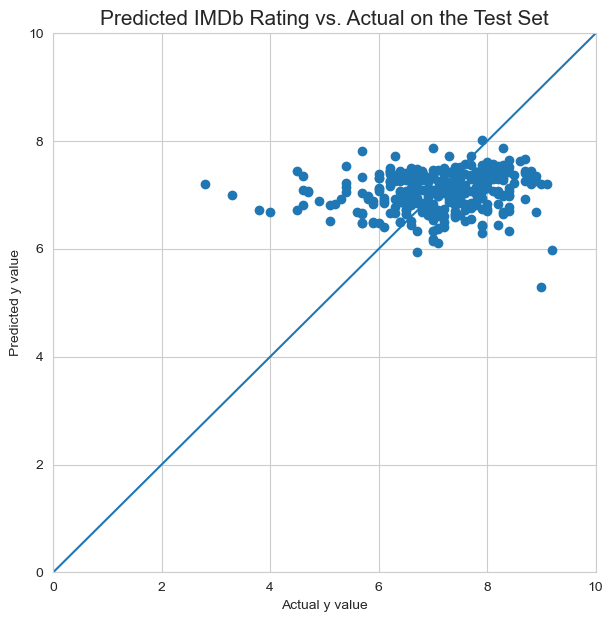

In [32]:
r_sq = lr.score(X_train.drop(columns=drop_col+['const'], axis=1), y_train)
print('coefficient of determination:', r_sq)

y_pred = lr.predict(X_test.drop(columns=drop_col+['const']))

df2 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(df2)

plt.figure(figsize=(7,7))
plt.title('Predicted IMDb Rating vs. Actual on the Test Set', fontsize=15)
plt.ylim(0,10)
plt.xlim(0,10)
plt.xlabel('Actual y value')
plt.ylabel('Predicted y value')
plt.scatter(y_test, y_pred)
plt.plot(range(11), range(11))
plt.savefig('KDE Plot of IMDb Rating', bbox_inches = 'tight');



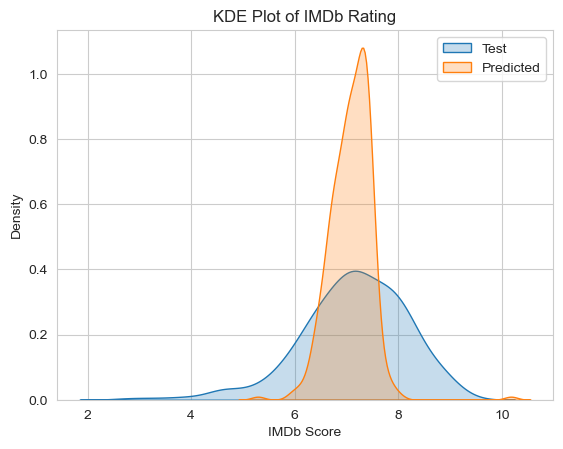

In [34]:
sns.kdeplot(y_test, fill=True)
sns.kdeplot(y_pred, fill=True)
plt.title('KDE Plot of IMDb Rating')
plt.xlabel('IMDb Score')
plt.ylabel('Density')
plt.legend(['Test','Predicted'])
plt.savefig('KDE Plot of IMDb Rating', bbox_inches = 'tight');

### Lasso

In [37]:
## Scaling the data
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [38]:
## Scaling the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [39]:
# Running the cross validation, finding the best alpha, refitting the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [40]:
# This is the best alpha value it found 
lasso_model.alpha_

0.0419870708444391

In [42]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))


[('const', 0.0),
 ('s01_episodes', 0.008448645950101896),
 ('avg_runtime', 0.06113785424659266),
 ('Thriller', 0.0),
 ('Music', 0.0),
 ('Comedy', 0.0),
 ('Biography', 0.017519820770371067),
 ('Adventure', 0.0),
 ('Horror', -0.0663133479941868),
 ('Documentary', 0.0),
 ('Western', 0.007675463881160543),
 ('Sci_Fi', -0.06372881208323164),
 ('Romance', 0.0019120883345700602),
 ('Short', -0.0),
 ('Mystery', -0.0),
 ('Action', -0.0),
 ('Family', -0.0),
 ('Game_Show', -0.0),
 ('News', 0.02950292532880514),
 ('Talk_Show', -0.03233333347552984),
 ('War', -0.0),
 ('Crime', 0.0),
 ('History', 0.0),
 ('Drama', 0.0),
 ('Reality_TV', -0.0),
 ('Animation', 0.02962083221843564),
 ('Musical', -0.0189709902619567),
 ('Sport', 0.044298954777604954),
 ('Fantasy', -0.0),
 ('genres_n', 0.006625237152507684),
 ('rel_month', 0.0),
 ('TV_PG', -0.05054727667165185),
 ('TV_14', -0.0),
 ('TV_MA', -0.0),
 ('made_in_usa', -0.1738396056967147),
 ('big_c', 0.0),
 ('company_n', 0.0),
 ('creators_a_n', 0.0),
 ('stars_

In [43]:
# Predictions at the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [44]:
# Finding the MAE and R^2 on the test set using this model
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

0.7822944958593693

In [45]:
r2_score(y_test, test_set_pred)

0.027798098275447436

LARS PATH - TO STUDY FEATURE IMPORTANCE

In [46]:
## Scale the variables
std = StandardScaler()
std.fit(X_train.values)


StandardScaler()

In [47]:
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

Computing regularization path using the LARS ...


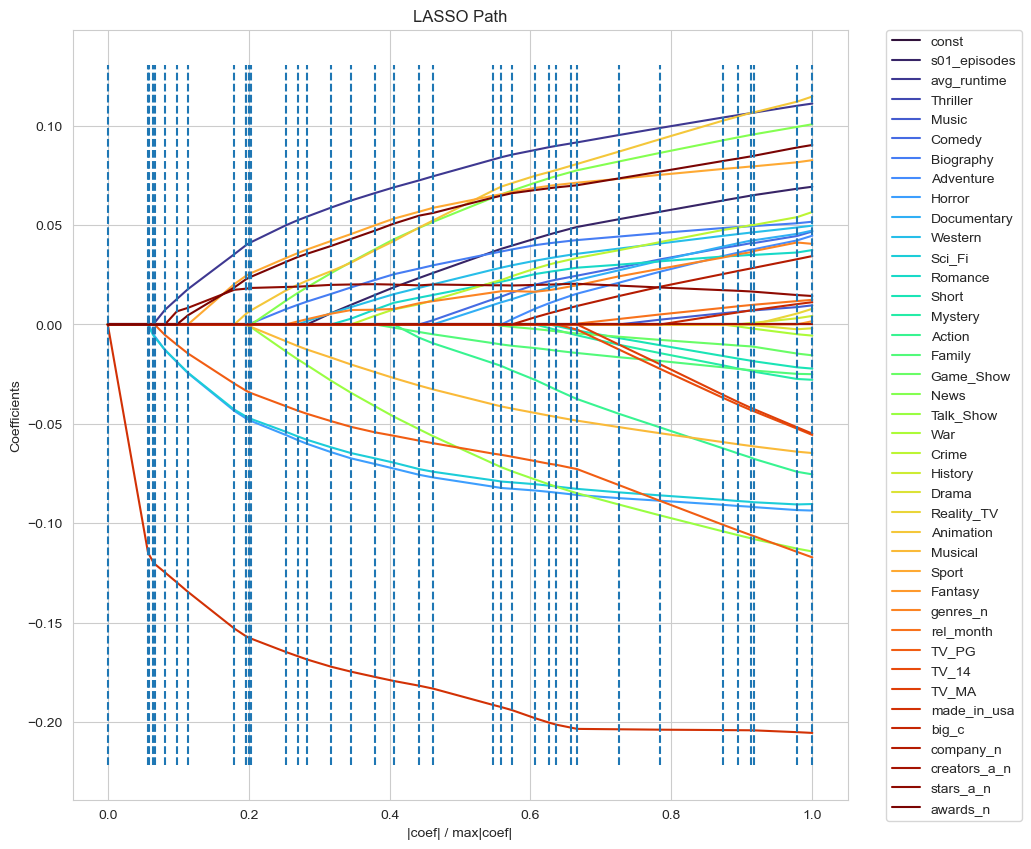

<Figure size 640x480 with 0 Axes>

In [78]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))

colors = cm.get_cmap('turbo')(np.linspace(0, 1, 40))
for i, column in enumerate(X_train.columns):
    color = cmap(i / len(X_train.columns))
    plt.plot(xx, coefs.T[:, i], label=column, color=colors[i])

ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()
plt.savefig('LASSO Path', bbox_inches = 'tight')


### Ridge model

In [79]:
## Scaling the data
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [80]:
## Scaling the Predictors on both the train and test set
X_tr = std.transform(X_train.values)
X_te = std.transform(X_test.values)

In [81]:
# Running the cross validation, finding the best alpha, refitting the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train)

RidgeCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [82]:
# This is the best alpha value it found 
ridge_model.alpha_

100.0

In [83]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
pd.DataFrame(list(zip(X_train.columns, ridge_model.coef_))).columns

RangeIndex(start=0, stop=2, step=1)

In [84]:
# Predictions at the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [85]:
# Finding the MAE and R^2 on the test set using this model
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

0.7812400936123753

In [86]:
r2_score(y_test, test_set_pred)

-0.003771067145760032